In [1]:
import os
import sys

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

from option import AsianOption, OptionType
from diffusion import GBM
from monte_carlo_engine import MonteCarloEngine

%matplotlib inline

In [2]:
S0     = 100
sigma  = 0.1
r      = 0.035
strike = 100
exp    = 1

opt = AsianOption(strike=strike, expiry=exp, option_type=OptionType.Call, n_fixings=12)
gbm = GBM(s0=S0, mu=r, sigma=sigma)
pricer = MonteCarloEngine(diffusion=gbm)

Convergence plot.

In [3]:
# Convergence experiment
n_steps = 252  # daily steps for 1y
max_paths = 50_000
eval_points = np.logspace(2, np.log10(max_paths), 30, dtype=int)

prices = []
conf_lower = []
conf_upper = []

for n in tqdm(eval_points):
    # Generate payoffs directly to compute variance
    payoffs = []
    for _ in range(n):
        spot_path = gbm.simulate_path(T=exp, n_steps=n_steps)
        payoffs.append(opt.payoff(spot_path))
    payoffs = np.array(payoffs)

    discount = np.exp(-r * exp)
    mean_price = discount * np.mean(payoffs)
    std_error  = discount * np.std(payoffs, ddof=1) / np.sqrt(n)

    ci95 = 1.96 * std_error
    prices.append(mean_price)
    conf_lower.append(mean_price - ci95)
    conf_upper.append(mean_price + ci95)

100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


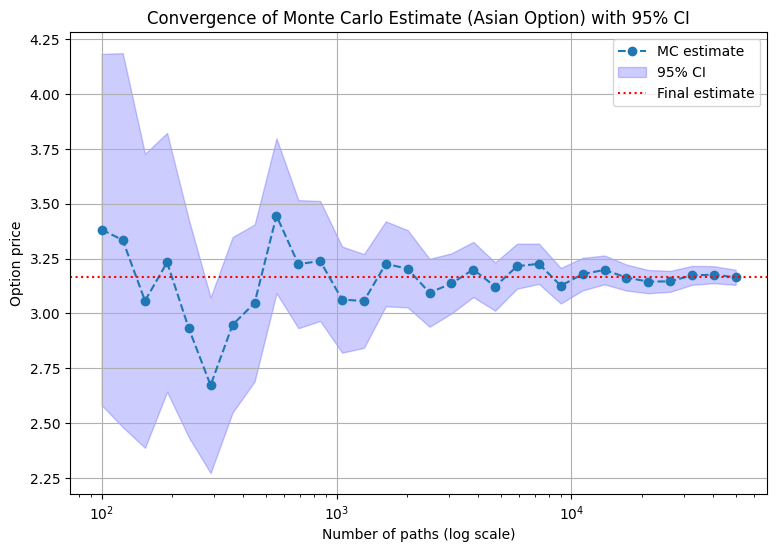

In [4]:
plt.figure(figsize=(9,6))
plt.plot(eval_points, prices, marker="o", linestyle="--", label="MC estimate")
plt.fill_between(eval_points, conf_lower, conf_upper, color="blue", alpha=0.2, label="95% CI")
plt.axhline(y=prices[-1], color="red", linestyle=":", label="Final estimate")
plt.xscale("log")
plt.xlabel("Number of paths (log scale)")
plt.ylabel("Option price")
plt.title("Convergence of Monte Carlo Estimate (Asian Option) with 95% CI")
plt.legend()
plt.grid(True)
plt.show()

Convergance comparison between different path generation schemes

In [7]:
# Storage for results
results = {
    "pseudorandom": {"prices": [], "conf_lower": [], "conf_upper": []},
    "sobol": {"prices": [], "conf_lower": [], "conf_upper": []},
}

for sampler in ["pseudorandom", "sobol"]:
    pricer = MonteCarloEngine(diffusion=gbm, seed=67)
    for n in tqdm(eval_points, desc=f"{sampler}"):
        # Use the engine's price method
        mean_price = pricer.price(option=opt, r=r, n_paths=n, n_steps=n_steps, sampler=sampler)

        # To compute CI, we need to re-run with full payoff collection
        # (so we get variance information). We'll do it here explicitly:
        payoffs = []
        for path in pricer.paths:  # pricer stores the last set of paths
            payoffs.append(opt.payoff(path))
        payoffs = np.array(payoffs)

        discount = np.exp(-r * exp)
        std_error = discount * np.std(payoffs, ddof=1) / np.sqrt(n)
        ci95 = 1.96 * std_error

        results[sampler]["prices"].append(mean_price)
        results[sampler]["conf_lower"].append(mean_price - ci95)
        results[sampler]["conf_upper"].append(mean_price + ci95)

sobol: 100%|██████████| 30/30 [00:14<00:00,  2.12it/s]


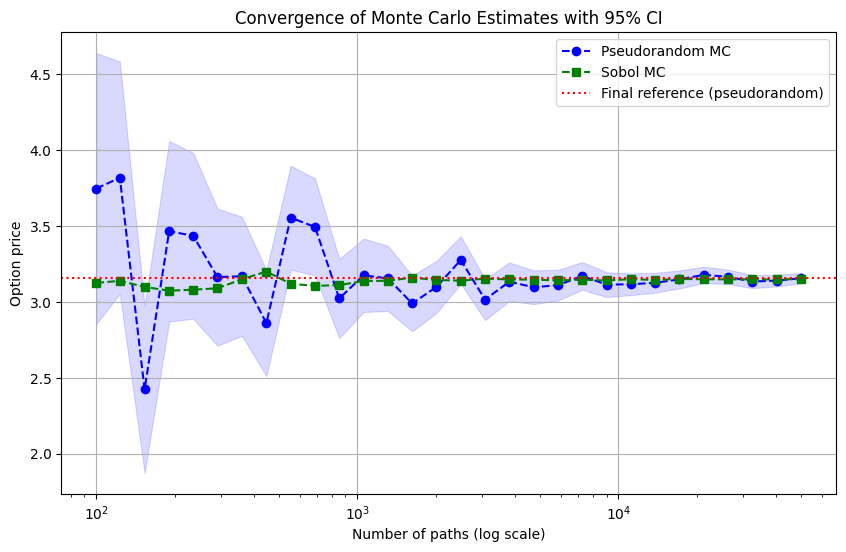

In [8]:
# Plotting
# Plotting with separate CIs
plt.figure(figsize=(10, 6))

# Pseudorandom
plt.plot(eval_points, results["pseudorandom"]["prices"], marker="o", linestyle="--",
         color="blue", label="Pseudorandom MC")
plt.fill_between(eval_points,
                 results["pseudorandom"]["conf_lower"],
                 results["pseudorandom"]["conf_upper"],
                 color="blue", alpha=0.15, edgecolor="blue", linewidth=0.8)

# Sobol
plt.plot(eval_points, results["sobol"]["prices"], marker="s", linestyle="--",
         color="green", label="Sobol MC")
plt.fill_between(eval_points,
                 results["sobol"]["conf_lower"],
                 results["sobol"]["conf_upper"],
                 color="none", hatch="////", edgecolor="green", linewidth=0.8)

plt.axhline(y=results["pseudorandom"]["prices"][-1], color="red", linestyle=":",
            label="Final reference (pseudorandom)")

plt.xscale("log")
plt.xlabel("Number of paths (log scale)")
plt.ylabel("Option price")
plt.title("Convergence of Monte Carlo Estimates with 95% CI")
plt.legend()
plt.grid(True)
plt.show()